In [1]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2024-07-31 14:02:06.119764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import data

In [2]:
data = pd.read_csv('Pediatrac INS SPSS July2024.csv')

In [3]:
# Isolate participants with EEG data
data = data.dropna(subset=['theta_1L']) # 45 x 718
data = data.reset_index(drop=True)

data

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,beta_4Z,beta_5Z,beta_6Z,beta_7Z,beta_1LA,beta_2LA,beta_3LA,beta_1RA,beta_2RA,beta_3RA
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,17.9366,2.8390,1.6313,2.7444,7.6048,1.1492,0.5495,17.5082,1.7390,1.2840
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,43.9943,0.9319,1.1284,2.7151,20.6170,5.9387,4.5441,15.8698,2.2798,4.8221
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,0.6150,0.7490,1.3686,1.3681,1.1419,0.7736,0.6574,3.1939,4.0956,0.7880
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,26.4816,7.0253,29.8763,123.0496,4.2275,14.7017,5.8257,1615.0269,15.3432,16.5328
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,2.1553,1.3879,4.0939,6.6537,2.6261,40.4650,16.0300,3.0206,3.6735,47.0423
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,1.2521,1.2354,1.0623,2.3119,3.7351,1.3982,0.7971,4.3478,1.2470,1.5817
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,1.9464,2.2726,2.1870,7.4386,6.0879,0.6361,1.2220,8.3357,3.3343,6.1580
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,4.1359,7.6566,1.1231,0.6773,12.4592,1.4893,2.2619,13.2960,1.2879,1.0775
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,1.9184,6.7375,1.3898,1.7070,2.9841,4.0070,5.5248,4.8248,2.5733,4.7913
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,1.9406,1.8285,2.9255,2.6064,2.1768,3.1625,2.9196,2.6451,5.7177,2.0979


In [4]:
# Define the function to calculate power for each frequency band
def calculate_power(data):
    data['theta_power'] = data.loc[:, 'theta_1L':'theta_3RA'].mean(axis=1)
    data['alpha_power'] = data.loc[:, 'alpha_1L':'alpha_3RA'].mean(axis=1)
    data['beta_power'] = data.loc[:, 'beta_1L':'beta_3RA'].mean(axis=1)
    return data

data = calculate_power(data)
display(data)

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,beta_7Z,beta_1LA,beta_2LA,beta_3LA,beta_1RA,beta_2RA,beta_3RA,theta_power,alpha_power,beta_power
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,2.7444,7.6048,1.1492,0.5495,17.5082,1.7390,1.2840,9.300432,5.401639,6.755218
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,2.7151,20.6170,5.9387,4.5441,15.8698,2.2798,4.8221,14.095182,8.391339,10.001475
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,1.3681,1.1419,0.7736,0.6574,3.1939,4.0956,0.7880,11.589136,4.794029,1.166879
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,123.0496,4.2275,14.7017,5.8257,1615.0269,15.3432,16.5328,427.575846,190.279264,79.484971
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,6.6537,2.6261,40.4650,16.0300,3.0206,3.6735,47.0423,21.671614,10.672346,8.566082
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,2.3119,3.7351,1.3982,0.7971,4.3478,1.2470,1.5817,12.271593,8.002904,1.940914
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,7.4386,6.0879,0.6361,1.2220,8.3357,3.3343,6.1580,23.435146,7.834996,5.376789
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,0.6773,12.4592,1.4893,2.2619,13.2960,1.2879,1.0775,33.683225,15.816532,6.802968
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,1.7070,2.9841,4.0070,5.5248,4.8248,2.5733,4.7913,29.372604,12.822450,2.940661
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,2.6064,2.1768,3.1625,2.9196,2.6451,5.7177,2.0979,18.023354,11.797446,3.456064


# Predicting theta, alpha, beta power values with wppsi

In [5]:
# List of potential target variables
target_vars = [
    'wppsi_bd_raw', # bd = block design; best pred. of visual/spacial IQ
    'wppsi_in_raw', # in = information; pred. verbial IQ
    'wppsi_pm_raw', # pm = pic. mem; visual-working mem
    'wppsi_fsiq_scaled',  # fsiq = full scale IQ; best est. of overall intellect
    #'wppsi_fsiq_ss'
]

# raw and ss are the same
# raw if using wppsi
# ss if using other measures (e.g. k-cpt)
# don't use descriptor variables

# Initialize variables to store the best results
best_mse = float('inf')
best_r2 = float('-inf')
best_target = None

# Iterate through each target variable
for target in target_vars:
    X = data[['theta_power', 'alpha_power', 'beta_power']]
    y = data[target]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Check if the current model is the best
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_target = target
    
    # Print evaluation metrics for current target variable
    print(f"Target variable: {target}")
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print()

# Print the best result
print("Best target variable based on Mean Squared Error and R-squared:")
print(f"Target variable: {best_target}")
print("Best Mean Squared Error:", best_mse)
print("Best R-squared:", best_r2)

Target variable: wppsi_bd_raw
Mean Squared Error: 235.4551235133685
R-squared: -263.8870139525396

Target variable: wppsi_in_raw
Mean Squared Error: 8.151996943965845
R-squared: -0.8548082934304309

Target variable: wppsi_pm_raw
Mean Squared Error: 195.00944544480666
R-squared: -7.974866523312125

Target variable: wppsi_fsiq_scaled
Mean Squared Error: 589.1474126479745
R-squared: -509.3843895666945

Best target variable based on Mean Squared Error and R-squared:
Target variable: wppsi_in_raw
Best Mean Squared Error: 8.151996943965845
Best R-squared: -0.8548082934304309


# Predicting theta, alpha, beta power values with k-cpt

In [6]:
# List of potential target (X) variables
target_vars = [
    'kcpt_detectability_t',
    'kcpt_omissions_t',
    'kcpt_commissions_t',
    'kcpt_hrt_score', 
    'kcpt_variability_t',
    'kcpt_hrt_block_tscore',
    'kcpt_hrt_isi_tscore',
]

# Initialize variables to store the best results
best_mse = float('inf')
best_r2 = float('-inf')
best_target = None

# Iterate through each target variable
for target in target_vars:
    print(f"Processing target variable: {target}")

    # Extract features and target variable
    X = data[['theta_power', 'alpha_power', 'beta_power']]
    y = data[target]
    
    # Check for NaN values in target variable
    if np.any(np.isnan(y)):
        print(f"NaN values found in target variable {target}. Handling missing values.")
        
        # Option 1: Remove rows with NaN values
        mask = ~np.isnan(y)
        X_clean = X[mask]
        y_clean = y[mask]
        
        # Option 2: Impute missing values with mean (uncomment if needed)
        # imputer = SimpleImputer(strategy='mean')
        # y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()
        # X_clean = X
        # y_clean = y_imputed
    else:
        X_clean = X
        y_clean = y
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Check if the current model is the best
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_target = target
    
    # Print evaluation metrics for current target variable
    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print()

# Print the best result
print("Best target variable based on Mean Squared Error:")
print(f"Target variable: {best_target}")
print("Best Mean Squared Error:", best_mse)
print("Best R-squared:", best_r2)

Processing target variable: kcpt_detectability_t
Mean Squared Error: 736.4952096179869
R-squared: -22.104613469812914

Processing target variable: kcpt_omissions_t
Mean Squared Error: 634.1109977283654
R-squared: -11.346872792307115

Processing target variable: kcpt_commissions_t
Mean Squared Error: 764.2751809291495
R-squared: -10.464127713937243

Processing target variable: kcpt_hrt_score
Mean Squared Error: 41.05532457048733
R-squared: 0.10364385708639501

Processing target variable: kcpt_variability_t
NaN values found in target variable kcpt_variability_t. Handling missing values.
Mean Squared Error: 36.05858211405334
R-squared: -0.22926984479727275

Processing target variable: kcpt_hrt_block_tscore
Mean Squared Error: 13527.05838544671
R-squared: -150.0049240933274

Processing target variable: kcpt_hrt_isi_tscore
Mean Squared Error: 9451.768997942354
R-squared: -125.58619193672796

Best target variable based on Mean Squared Error:
Target variable: kcpt_variability_t
Best Mean Squa

# Predicting dominant frequency using wppsi 

In [7]:
# Extract features and power columns
features = ['wppsi_bd_raw', 'wppsi_in_raw', 
            'wppsi_pm_raw', 'wppsi_fsiq_scaled'] 
power_columns = ['theta_power', 'alpha_power', 'beta_power']

# Determine the dominant power
data['dominate_power'] = data[power_columns].idxmax(axis=1)

# Encode the target variable
encoder = LabelEncoder()
data['dominate_power_encoded'] = encoder.fit_transform(data['dominate_power'])

# Split the data into features and target
X = data[features]
y = data['dominate_power_encoded']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Predict dominant power for the entire dataset
y_pred_full = model.predict(X_scaled)
y_pred_full_labels = np.argmax(y_pred_full, axis=1)
predicted_power_full = encoder.inverse_transform(y_pred_full_labels)

# Add predictions to the full dataset 
data['predicted_power'] = predicted_power_full

display(data)


Epoch 1/15


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1250 - loss: 0.7703 - val_accuracy: 0.5000 - val_loss: 0.6894
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5958 - loss: 0.6877 - val_accuracy: 1.0000 - val_loss: 0.6392
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9792 - loss: 0.6280 - val_accuracy: 1.0000 - val_loss: 0.5901
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9792 - loss: 0.5646 - val_accuracy: 1.0000 - val_loss: 0.5429
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9792 - loss: 0.5108 - val_accuracy: 1.0000 - val_loss: 0.4941
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9792 - loss: 0.4496 - val_accuracy: 1.0000 - val_loss: 0.4417
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9792 - loss: 0.3909 - val_accuracy: 1.0000 - val_loss: 0.3896
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9667 - loss: 0.3473 - val_accuracy: 1.0000 - val_loss: 0.3405
Epoch 9/15

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,beta_3LA,beta_1RA,beta_2RA,beta_3RA,theta_power,alpha_power,beta_power,dominate_power,dominate_power_encoded,predicted_power
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,0.5495,17.5082,1.7390,1.2840,9.300432,5.401639,6.755218,theta_power,1,theta_power
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,4.5441,15.8698,2.2798,4.8221,14.095182,8.391339,10.001475,theta_power,1,theta_power
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,0.6574,3.1939,4.0956,0.7880,11.589136,4.794029,1.166879,theta_power,1,theta_power
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,5.8257,1615.0269,15.3432,16.5328,427.575846,190.279264,79.484971,theta_power,1,theta_power
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,16.0300,3.0206,3.6735,47.0423,21.671614,10.672346,8.566082,theta_power,1,theta_power
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,0.7971,4.3478,1.2470,1.5817,12.271593,8.002904,1.940914,theta_power,1,theta_power
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,1.2220,8.3357,3.3343,6.1580,23.435146,7.834996,5.376789,theta_power,1,theta_power
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,2.2619,13.2960,1.2879,1.0775,33.683225,15.816532,6.802968,theta_power,1,theta_power
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,5.5248,4.8248,2.5733,4.7913,29.372604,12.822450,2.940661,theta_power,1,theta_power
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,2.9196,2.6451,5.7177,2.0979,18.023354,11.797446,3.456064,theta_power,1,theta_power


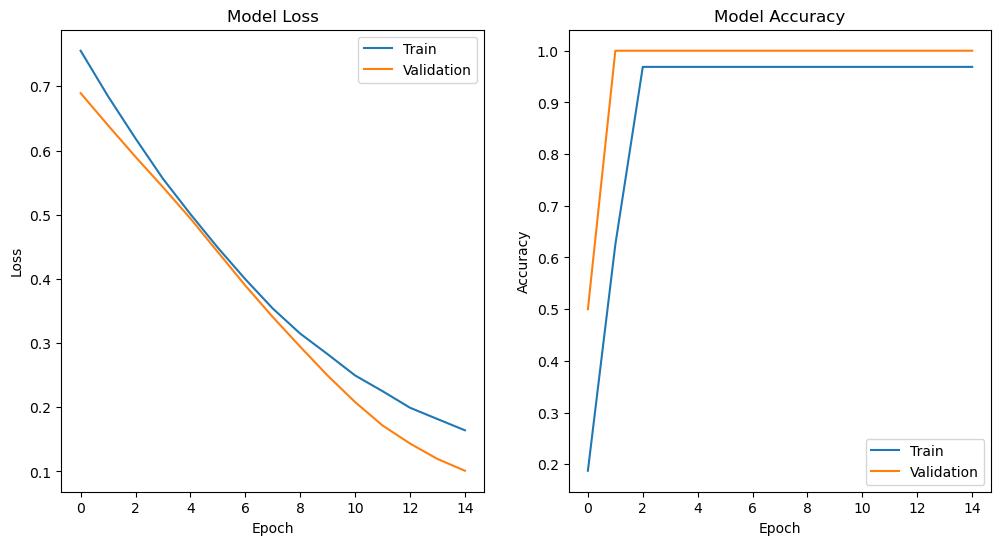

In [8]:
# row 27 get rid of outlier
# seperate term and pre-term ... avg. theta

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()


# Predicting dominant frequency using k-cpt

In [9]:
# Extract features and power columns
features = ['kcpt_detectability_t', 'kcpt_omissions_t',
            'kcpt_commissions_t', 'kcpt_perseverations_t',
            'kcpt_hrt_score', 'kcpt_variability_t', 'kcpt_hrt_block_tscore',
            'kcpt_hrt_isi_tscore']
power_columns = ['theta_power', 'alpha_power', 'beta_power']

# Determine the dominant power
data['dominate_power'] = data[power_columns].idxmax(axis=1)

# Encode the target variable
encoder = LabelEncoder()
data['dominate_power_encoded'] = encoder.fit_transform(data['dominate_power'])

# Split the data into features and target
X = data[features]
y = data['dominate_power_encoded']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=8, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Predict dominant power for the entire dataset
y_pred_full = model.predict(X_scaled)
y_pred_full_labels = np.argmax(y_pred_full, axis=1)
predicted_power_full = encoder.inverse_transform(y_pred_full_labels)

# Add predictions to the full dataset
data['predicted_power'] = predicted_power_full

display(data)

Epoch 1/15


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.1958 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0208 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0333 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0208 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0208 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0125 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0125 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0333 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 9/15
4/4 ━━━━━━━━━━━━

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,beta_3LA,beta_1RA,beta_2RA,beta_3RA,theta_power,alpha_power,beta_power,dominate_power,dominate_power_encoded,predicted_power
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,0.5495,17.5082,1.7390,1.2840,9.300432,5.401639,6.755218,theta_power,1,alpha_power
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,4.5441,15.8698,2.2798,4.8221,14.095182,8.391339,10.001475,theta_power,1,alpha_power
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,0.6574,3.1939,4.0956,0.7880,11.589136,4.794029,1.166879,theta_power,1,alpha_power
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,5.8257,1615.0269,15.3432,16.5328,427.575846,190.279264,79.484971,theta_power,1,alpha_power
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,16.0300,3.0206,3.6735,47.0423,21.671614,10.672346,8.566082,theta_power,1,alpha_power
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,0.7971,4.3478,1.2470,1.5817,12.271593,8.002904,1.940914,theta_power,1,alpha_power
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,1.2220,8.3357,3.3343,6.1580,23.435146,7.834996,5.376789,theta_power,1,alpha_power
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,2.2619,13.2960,1.2879,1.0775,33.683225,15.816532,6.802968,theta_power,1,alpha_power
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,5.5248,4.8248,2.5733,4.7913,29.372604,12.822450,2.940661,theta_power,1,alpha_power
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,2.9196,2.6451,5.7177,2.0979,18.023354,11.797446,3.456064,theta_power,1,alpha_power


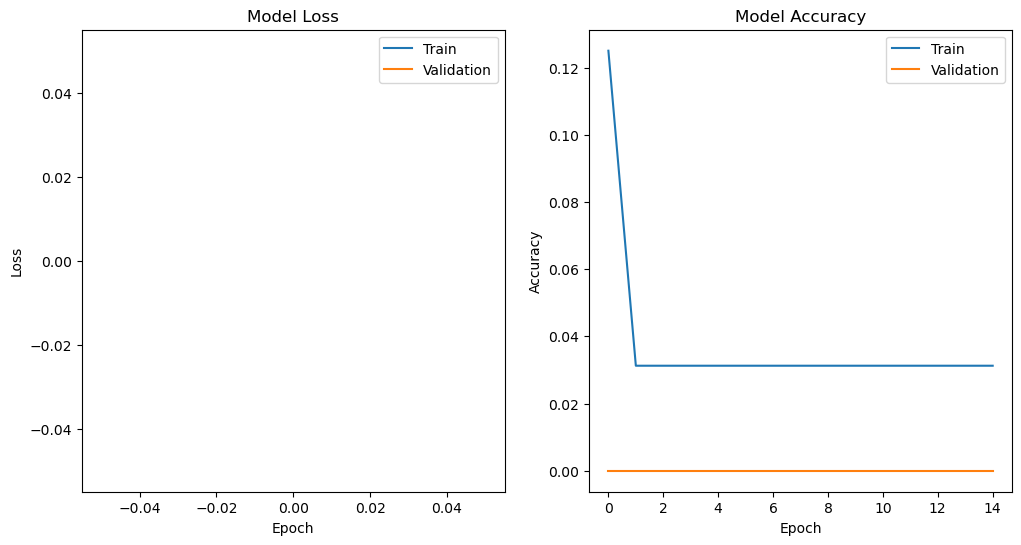

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

# Predicting wppsi_fsiq_scaled using frequency band data

In [11]:
# scaled = derived from raw scores
# ss = translated to IQ scale
# run code using ss

# 27 features to predict cognitive test
# Check 64 features

# Calculate means for alpha band features
data['alpha_left'] = data[['alpha_1L', 'alpha_2L', 'alpha_3L', 'alpha_4L', 'alpha_5L', 'alpha_6L', 'alpha_7L',
                           'alpha_1LA', 'alpha_2LA', 'alpha_3LA']].mean(axis=1)
data['alpha_right'] = data[['alpha_1R', 'alpha_2R', 'alpha_3R', 'alpha_4R', 'alpha_5R', 'alpha_6R', 'alpha_7R',
                            'alpha_1RA', 'alpha_2RA', 'alpha_3RA']].mean(axis=1)
data['alpha_frontal'] = data[['alpha_1L', 'alpha_2L', 'alpha_3L', 'alpha_4L', 'alpha_1R', 'alpha_2R', 'alpha_3R', 'alpha_4R',
                              'alpha_0Z', 'alpha_1Z', 'alpha_2Z', 'alpha_3Z', 'alpha_1LA', 'alpha_1RA']].mean(axis=1)
data['alpha_right_frontal'] = data[['alpha_1R', 'alpha_2R', 'alpha_3R', 'alpha_4R', 'alpha_1RA']].mean(axis=1)
data['alpha_left_frontal'] = data[['alpha_1L', 'alpha_2L', 'alpha_3L', 'alpha_4L', 'alpha_1LA']].mean(axis=1)
data['alpha_parietal'] = data[['alpha_6L', 'alpha_7L', 'alpha_6R', 'alpha_7R', 'alpha_5Z',
                               'alpha_6Z', 'alpha_7Z', 'alpha_3LA', 'alpha_3RA']].mean(axis=1)
data['alpha_right_parietal'] = data[['alpha_6R', 'alpha_7R', 'alpha_3RA']].mean(axis=1)
data['alpha_left_parietal'] = data[['alpha_6L', 'alpha_7L', 'alpha_3LA']].mean(axis=1)

# Calculate means for beta band features
data['beta_left'] = data[['beta_1L', 'beta_2L', 'beta_3L', 'beta_4L', 'beta_5L', 'beta_6L', 'beta_7L',
                          'beta_1LA', 'beta_2LA', 'beta_3LA']].mean(axis=1)
data['beta_right'] = data[['beta_1R', 'beta_2R', 'beta_3R', 'beta_4R', 'beta_5R', 'beta_6R', 'beta_7R',
                           'beta_1RA', 'beta_2RA', 'beta_3RA']].mean(axis=1)
data['beta_frontal'] = data[['beta_1L', 'beta_2L', 'beta_3L', 'beta_4L', 'beta_1R', 'beta_2R', 'beta_3R', 'beta_4R',
                             'beta_0Z', 'beta_1Z', 'beta_2Z', 'beta_3Z', 'beta_1LA', 'beta_1RA']].mean(axis=1)
data['beta_right_frontal'] = data[['beta_1R', 'beta_2R', 'beta_3R', 'beta_4R', 'beta_1RA']].mean(axis=1)
data['beta_left_frontal'] = data[['beta_1L', 'beta_2L', 'beta_3L', 'beta_4L', 'beta_1LA']].mean(axis=1)
data['beta_parietal'] = data[['beta_6L', 'beta_7L', 'beta_6R', 'beta_7R', 'beta_5Z',
                              'beta_6Z', 'beta_7Z', 'beta_3LA', 'beta_3RA']].mean(axis=1)
data['beta_right_parietal'] = data[['beta_6R', 'beta_7R', 'beta_3RA']].mean(axis=1)
data['beta_left_parietal'] = data[['beta_6L', 'beta_7L', 'beta_3LA']].mean(axis=1)

# Calculate means for theta band features
data['theta_left'] = data[['theta_1L', 'theta_2L', 'theta_3L', 'theta_4L', 'theta_5L', 'theta_6L', 'theta_7L',
                           'theta_1LA', 'theta_2LA', 'theta_3LA']].mean(axis=1)
data['theta_right'] = data[['theta_1R', 'theta_2R', 'theta_3R', 'theta_4R', 'theta_5R', 'theta_6R', 'theta_7R',
                            'theta_1RA', 'theta_2RA', 'theta_3RA']].mean(axis=1)
data['theta_frontal'] = data[['theta_1L', 'theta_2L', 'theta_3L', 'theta_4L', 'theta_1R', 'theta_2R', 'theta_3R', 'theta_4R',
                              'theta_0Z', 'theta_1Z', 'theta_2Z', 'theta_3Z', 'theta_1LA', 'theta_1RA']].mean(axis=1)
data['theta_right_frontal'] = data[['theta_1R', 'theta_2R', 'theta_3R', 'theta_4R', 'theta_1RA']].mean(axis=1)
data['theta_left_frontal'] = data[['theta_1L', 'theta_2L', 'theta_3L', 'theta_4L', 'theta_1LA']].mean(axis=1)
data['theta_parietal'] = data[['theta_6L', 'theta_7L', 'theta_6R', 'theta_7R', 'theta_5Z',
                               'theta_6Z', 'theta_7Z', 'theta_3LA', 'theta_3RA']].mean(axis=1)
data['theta_right_parietal'] = data[['theta_6R', 'theta_7R', 'theta_3RA']].mean(axis=1)
data['theta_left_parietal'] = data[['theta_6L', 'theta_7L', 'theta_3LA']].mean(axis=1)


In [12]:
data

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,beta_right_parietal,beta_left_parietal,theta_left,theta_right,theta_frontal,theta_right_frontal,theta_left_frontal,theta_parietal,theta_right_parietal,theta_left_parietal
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,1.230300,1.280667,6.58840,10.22356,12.048700,15.60986,9.29638,6.301378,4.171633,3.199600
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,12.438800,12.742600,15.35334,15.81842,12.907436,13.97816,12.87548,14.787700,19.486133,16.682133
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,0.752000,0.687600,10.41554,12.29487,12.368757,13.32140,11.36078,11.040500,10.579500,10.506033
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,9.456700,88.028367,135.25989,1012.29573,718.224243,1969.75662,19.72366,174.073000,55.932133,372.487100
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,21.834333,8.543600,20.01486,26.67945,16.723029,16.67610,15.72360,21.054756,26.807433,21.216967
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,1.646900,2.471300,11.28315,13.61965,14.920271,18.12138,12.45620,10.020978,10.007233,11.128733
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,3.476667,2.095167,13.74619,30.44358,17.925514,25.03100,14.55906,32.586900,34.353633,15.542600
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,5.259933,3.303500,43.96027,30.38736,41.042507,28.23816,59.13574,28.035267,36.411767,34.845700
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,3.350933,4.919833,25.50545,23.97437,20.466607,24.75582,17.08932,46.567878,28.845800,36.347567
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,5.457533,4.495433,17.22131,18.34874,16.520950,16.39108,15.18370,19.779978,19.547700,21.222133


Epoch 1/35


/var/folders/q9/0487pnyj0qv0w1ky3fjzljb80000gn/T/ipykernel_17747/2473680376.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)  # Example: replacing NaNs with 0
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 131.7160 - mae: 11.2409 - val_loss: 118.7470 - val_mae: 10.8150
Epoch 2/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 125.5043 - mae: 10.9281 - val_loss: 114.3598 - val_mae: 10.6078
Epoch 3/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 115.4219 - mae: 10.4560 - val_loss: 108.5606 - val_mae: 10.3257
Epoch 4/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 110.1682 - mae: 10.1918 - val_loss: 101.3335 - val_mae: 9.9647
Epoch 5/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 107.4926 - mae: 10.0903 - val_loss: 92.9145 - val_mae: 9.5271
Epoch 6/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 86.0204 - mae: 8.9447 - val_loss: 83.6675 - val_mae: 9.0201
Epoch 7/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 84.1677 - mae: 8.7873 - val_loss: 73.4507 - val_mae: 8.4251
Epoch 8/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 81.1192 - mae: 8.5699 - val_loss: 61.7644 - val_mae: 7.6842
Epoch 9/35
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6

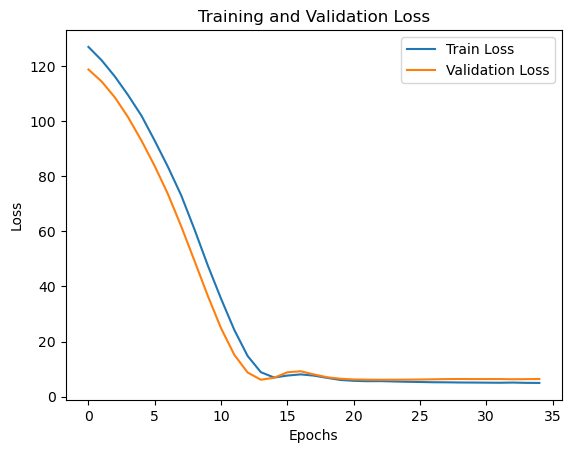

In [13]:
# some of these variables double dip. use new datasets (alpha, beta, theta, gamma)

# Define the feature set
# features = ['alpha_right', 'alpha_left', 'alpha_frontal', 'alpha_right_frontal', 'alpha_left_frontal', 
#            'alpha_parietal', 'alpha_right_parietal', 'alpha_left_parietal', 'beta_right', 'beta_left',
#            'beta_frontal', 'beta_right_frontal', 'beta_left_frontal', 'beta_parietal', 'beta_right_parietal',
#            'beta_left_parietal', 'theta_right', 'theta_left', 'theta_frontal', 'theta_right_frontal','theta_left_frontal',
#            'theta_parietal', 'theta_right_parietal', 'theta_left_parietal']

features = ['theta_1L', 'theta_2L','theta_3L','theta_4L','theta_5L','theta_6L','theta_7L','theta_1R','theta_2R','theta_3R','theta_4R','theta_5R','theta_6R','theta_7R','theta_0Z','theta_1Z','theta_2Z',
            'theta_3Z','theta_4Z','theta_5Z','theta_6Z','theta_7Z','theta_1LA','theta_2LA','theta_3LA','theta_1RA','theta_2RA','theta_3RA','alpha_1L',
            'alpha_2L','alpha_3L','alpha_4L','alpha_5L','alpha_6L','alpha_7L','alpha_1R','alpha_2R','alpha_3R','alpha_4R','alpha_5R','alpha_6R','alpha_7R','alpha_0Z','alpha_1Z','alpha_2Z','alpha_3Z',
            'alpha_4Z','alpha_5Z','alpha_6Z','alpha_7Z','alpha_1LA','alpha_2LA','alpha_3LA','alpha_1RA','alpha_2RA','alpha_3RA','beta_1L','beta_2L','beta_3L','beta_4L',
            'beta_5L','beta_6L','beta_7L','beta_1R','beta_2R','beta_3R','beta_4R','beta_5R','beta_6R','beta_7R','beta_0Z','beta_1Z','beta_2Z','beta_3Z','beta_4Z','beta_5Z','beta_6Z','beta_7Z','beta_1LA',
            'beta_2LA','beta_3LA','beta_1RA','beta_2RA','beta_3RA']

# Split the data into features and target
X = data[features]
y = data['wppsi_fsiq_scaled']

# Check for missing values and handle them if any
X.fillna(0, inplace=True)  # Example: replacing NaNs with 0

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the neural network model for regression
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=35, batch_size=8, validation_split=0.1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}, Test MAE: {mae}')

# Predict IQ scores for the entire dataset
y_pred_full = model.predict(X_scaled)

# Add predictions to the full dataset
data['wppsi_fsiq_scaled_predicted'] = y_pred_full

# Visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [14]:
data

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,beta_left_parietal,theta_left,theta_right,theta_frontal,theta_right_frontal,theta_left_frontal,theta_parietal,theta_right_parietal,theta_left_parietal,wppsi_fsiq_scaled_predicted
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,1.280667,6.58840,10.22356,12.048700,15.60986,9.29638,6.301378,4.171633,3.199600,11.576233
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,12.742600,15.35334,15.81842,12.907436,13.97816,12.87548,14.787700,19.486133,16.682133,10.289404
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,0.687600,10.41554,12.29487,12.368757,13.32140,11.36078,11.040500,10.579500,10.506033,12.482645
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,88.028367,135.25989,1012.29573,718.224243,1969.75662,19.72366,174.073000,55.932133,372.487100,12.366261
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,8.543600,20.01486,26.67945,16.723029,16.67610,15.72360,21.054756,26.807433,21.216967,10.102083
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,2.471300,11.28315,13.61965,14.920271,18.12138,12.45620,10.020978,10.007233,11.128733,11.977904
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,2.095167,13.74619,30.44358,17.925514,25.03100,14.55906,32.586900,34.353633,15.542600,11.090337
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,3.303500,43.96027,30.38736,41.042507,28.23816,59.13574,28.035267,36.411767,34.845700,8.769434
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,4.919833,25.50545,23.97437,20.466607,24.75582,17.08932,46.567878,28.845800,36.347567,10.444098
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,4.495433,17.22131,18.34874,16.520950,16.39108,15.18370,19.779978,19.547700,21.222133,10.908081


In [15]:
display(data[['wppsi_fsiq_scaled', 'wppsi_fsiq_scaled_predicted']])

,wppsi_fsiq_scaled,wppsi_fsiq_scaled_predicted
0,12.0,11.576233
1,9.5,10.289404
2,8.0,12.482645
3,12.5,12.366261
4,11.5,10.102083
5,12.0,11.977904
6,9.0,11.090337
7,13.0,8.769434
8,12.0,10.444098
9,11.0,10.908081


In [16]:
display(data[['term', 'wppsi_fsiq_scaled']])

,term,wppsi_fsiq_scaled
0,Full-Term,12.0
1,Full-Term,9.5
2,Full-Term,8.0
3,Full-Term,12.5
4,Full-Term,11.5
5,Full-Term,12.0
6,Full-Term,9.0
7,Full-Term,13.0
8,Full-Term,12.0
9,Full-Term,11.0


# Import all channel data and train ML model

In [17]:
# do the same thing but with all channels
# try feature importance/combos

alpha = pd.read_excel('TFalpha_extraction_Alpha_20240726_AllChannels.xlsx')
beta = pd.read_excel('TFalpha_extraction_Beta_20240726_AllChannels.xlsx')
gamma = pd.read_excel('TFalpha_extraction_Gamma_20240726_AllChannels.xlsx')
theta = pd.read_excel('TFalpha_extraction_Theta_20240726_AllChannels.xlsx')

In [18]:
# Merge the result with alpha
data = data.merge(beta, left_on='part_id', right_on='Row', suffixes=('', '_alpha'))

# Merge the result with beta
data = data.merge(beta, left_on='part_id', right_on='Row', suffixes=('', '_beta'))

# Merge the result with gamma
data = data.merge(gamma, left_on='part_id', right_on='Row', suffixes=('', '_gamma'))

# Merge the result with theta
data = data.merge(theta, left_on='part_id', right_on='Row', suffixes=('', '_theta'))

In [19]:
display(data)

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,0_2000ms_Rest_4LB_theta,0_2000ms_Rest_4RB_theta,0_2000ms_Rest_4Z_theta,0_2000ms_Rest_2RB_theta,0_2000ms_Rest_1RD_theta,0_2000ms_Rest_3LC_theta,0_2000ms_Rest_3RC_theta,0_2000ms_Rest_6R_theta,0_2000ms_Rest_5L_theta,0_2000ms_Rest_5Z_theta
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,3.0922,3.2352,13.5432,12.8346,19.0136,1.7250,2.7894,1.0528,3.2047,23.6806
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,6.9506,7.3600,11.9271,9.0588,11.4491,6.7059,12.0505,24.4020,18.2411,7.7072
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,2.2369,4.7518,11.5321,12.4316,12.4207,6.7131,1.7917,8.4249,7.3225,10.5674
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,109.7264,194.9774,107.4302,11.9455,21.4704,64.6638,73.6026,25.6803,35.1055,30.1897
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,12.1277,16.0422,22.3186,19.9865,20.5538,14.2917,25.1456,21.3517,23.4827,16.4357
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,5.3210,2.1031,11.7998,14.8279,21.9403,2.2147,13.2087,13.1622,10.8440,10.8754
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,20.3005,12.3243,17.6861,27.1247,323.7350,15.9067,6.3273,13.8123,12.4327,37.1816
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,20.3646,19.0760,23.3834,48.7163,26.4622,23.6517,32.9028,33.7793,21.3412,21.1221
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,11.6104,13.1900,26.7971,23.2695,24.7335,17.9454,15.8034,20.3788,24.9981,201.8964
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,11.5146,11.9798,19.8237,13.4814,8.7331,12.9186,13.2129,11.0422,13.2559,26.4701


In [20]:
data.rename(columns={
    '0_2000ms_Rest_0Z': '0Z_alpha',
    '0_2000ms_Rest_1Z': '1Z_alpha',
    '0_2000ms_Rest_2Z': '2Z_alpha',
    '0_2000ms_Rest_3Z': '3Z_alpha',
    '0_2000ms_Rest_1L': '1L_alpha',
    '0_2000ms_Rest_1R': '1R_alpha',
    '0_2000ms_Rest_1LB': '1LB_alpha',
    '0_2000ms_Rest_1RB': '1RB_alpha',
    '0_2000ms_Rest_2L': '2L_alpha',
    '0_2000ms_Rest_2R': '2R_alpha',
    '0_2000ms_Rest_3L': '3L_alpha',
    '0_2000ms_Rest_3R': '3R_alpha',
    '0_2000ms_Rest_4L': '4L_alpha',
    '0_2000ms_Rest_4R': '4R_alpha',
    '0_2000ms_Rest_1LC': '1LC_alpha',
    '0_2000ms_Rest_1RC': '1RC_alpha',
    '0_2000ms_Rest_2LB': '2LB_alpha',
    '0_2000ms_Rest_1LA': '1LA_alpha',
    '0_2000ms_Rest_1RA': '1RA_alpha',
    '0_2000ms_Rest_1LD': '1LD_alpha',
    '0_2000ms_Rest_2LC': '2LC_alpha',
    '0_2000ms_Rest_2RC': '2RC_alpha',
    '0_2000ms_Rest_3LB': '3LB_alpha',
    '0_2000ms_Rest_3RB': '3RB_alpha',
    '0_2000ms_Rest_2LD': '2LD_alpha',
    '0_2000ms_Rest_2RD': '2RD_alpha',
    '0_2000ms_Rest_3RD': '3RD_alpha',
    '0_2000ms_Rest_3LD': '3LD_alpha',
    '0_2000ms_Rest_9Z': '9Z_alpha',
    '0_2000ms_Rest_8Z': '8Z_alpha',
    '0_2000ms_Rest_7Z': '7Z_alpha',
    '0_2000ms_Rest_6Z': '6Z_alpha',
    '0_2000ms_Rest_10L': '10L_alpha',
    '0_2000ms_Rest_10R': '10R_alpha',
    '0_2000ms_Rest_9L': '9L_alpha',
    '0_2000ms_Rest_9R': '9R_alpha',
    '0_2000ms_Rest_8L': '8L_alpha',
    '0_2000ms_Rest_8R': '8R_alpha',
    '0_2000ms_Rest_7L': '7L_alpha',
    '0_2000ms_Rest_7R': '7R_alpha',
    '0_2000ms_Rest_6L': '6L_alpha',
    '0_2000ms_Rest_5R': '5R_alpha',
    '0_2000ms_Rest_4LD': '4LD_alpha',
    '0_2000ms_Rest_4RD': '4RD_alpha',
    '0_2000ms_Rest_5LC': '5LC_alpha',
    '0_2000ms_Rest_5RC': '5RC_alpha',
    '0_2000ms_Rest_5LB': '5LB_alpha',
    '0_2000ms_Rest_5RB': '5RB_alpha',
    '0_2000ms_Rest_3LA': '3LA_alpha',
    '0_2000ms_Rest_3RA': '3RA_alpha',
    '0_2000ms_Rest_2LA': '2LA_alpha',
    '0_2000ms_Rest_2RA': '2RA_alpha',
    '0_2000ms_Rest_4LC': '4LC_alpha',
    '0_2000ms_Rest_4RC': '4RC_alpha',
    '0_2000ms_Rest_4LB': '4LB_alpha',
    '0_2000ms_Rest_4RB': '4RB_alpha',
    '0_2000ms_Rest_4Z': '4Z_alpha',
    '0_2000ms_Rest_2RB': '2RB_alpha',
    '0_2000ms_Rest_1RD': '1RD_alpha',
    '0_2000ms_Rest_3LC': '3LC_alpha',
    '0_2000ms_Rest_3RC': '3RC_alpha',
    '0_2000ms_Rest_6R': '6R_alpha',
    '0_2000ms_Rest_5L': '5L_alpha',
    '0_2000ms_Rest_5Z': '5Z_alpha',
    
    '0_2000ms_Rest_0Z_beta': '0Z_beta',
    '0_2000ms_Rest_1Z_beta': '1Z_beta',
    '0_2000ms_Rest_2Z_beta': '2Z_beta',
    '0_2000ms_Rest_3Z_beta': '3Z_beta',
    '0_2000ms_Rest_1L_beta': '1L_beta',
    '0_2000ms_Rest_1R_beta': '1R_beta',
    '0_2000ms_Rest_1LB_beta': '1LB_beta',
    '0_2000ms_Rest_1RB_beta': '1RB_beta',
    '0_2000ms_Rest_2L_beta': '2L_beta',
    '0_2000ms_Rest_2R_beta': '2R_beta',
    '0_2000ms_Rest_3L_beta': '3L_beta',
    '0_2000ms_Rest_3R_beta': '3R_beta',
    '0_2000ms_Rest_4L_beta': '4L_beta',
    '0_2000ms_Rest_4R_beta': '4R_beta',
    '0_2000ms_Rest_1LC_beta': '1LC_beta',
    '0_2000ms_Rest_1RC_beta': '1RC_beta',
    '0_2000ms_Rest_2LB_beta': '2LB_beta',
    '0_2000ms_Rest_1LA_beta': '1LA_beta',
    '0_2000ms_Rest_1RA_beta': '1RA_beta',
    '0_2000ms_Rest_1LD_beta': '1LD_beta',
    '0_2000ms_Rest_2LC_beta': '2LC_beta',
    '0_2000ms_Rest_2RC_beta': '2RC_beta',
    '0_2000ms_Rest_3LB_beta': '3LB_beta',
    '0_2000ms_Rest_3RB_beta': '3RB_beta',
    '0_2000ms_Rest_2LD_beta': '2LD_beta',
    '0_2000ms_Rest_2RD_beta': '2RD_beta',
    '0_2000ms_Rest_3RD_beta': '3RD_beta',
    '0_2000ms_Rest_3LD_beta': '3LD_beta',
    '0_2000ms_Rest_9Z_beta': '9Z_beta',
    '0_2000ms_Rest_8Z_beta': '8Z_beta',
    '0_2000ms_Rest_7Z_beta': '7Z_beta',
    '0_2000ms_Rest_6Z_beta': '6Z_beta',
    '0_2000ms_Rest_10L_beta': '10L_beta',
    '0_2000ms_Rest_10R_beta': '10R_beta',
    '0_2000ms_Rest_9L_beta': '9L_beta',
    '0_2000ms_Rest_9R_beta': '9R_beta',
    '0_2000ms_Rest_8L_beta': '8L_beta',
    '0_2000ms_Rest_8R_beta': '8R_beta',
    '0_2000ms_Rest_7L_beta': '7L_beta',
    '0_2000ms_Rest_7R_beta': '7R_beta',
    '0_2000ms_Rest_6L_beta': '6L_beta',
    '0_2000ms_Rest_5R_beta': '5R_beta',
    '0_2000ms_Rest_4LD_beta': '4LD_beta',
    '0_2000ms_Rest_4RD_beta': '4RD_beta',
    '0_2000ms_Rest_5LC_beta': '5LC_beta',
    '0_2000ms_Rest_5RC_beta': '5RC_beta',
    '0_2000ms_Rest_5LB_beta': '5LB_beta',
    '0_2000ms_Rest_5RB_beta': '5RB_beta',
    '0_2000ms_Rest_3LA_beta': '3LA_beta',
    '0_2000ms_Rest_3RA_beta': '3RA_beta',
    '0_2000ms_Rest_2LA_beta': '2LA_beta',
    '0_2000ms_Rest_2RA_beta': '2RA_beta',
    '0_2000ms_Rest_4LC_beta': '4LC_beta',
    '0_2000ms_Rest_4RC_beta': '4RC_beta',
    '0_2000ms_Rest_4LB_beta': '4LB_beta',
    '0_2000ms_Rest_4RB_beta': '4RB_beta',
    '0_2000ms_Rest_4Z_beta': '4Z_beta',
    '0_2000ms_Rest_2RB_beta': '2RB_beta',
    '0_2000ms_Rest_1RD_beta': '1RD_beta',
    '0_2000ms_Rest_3LC_beta': '3LC_beta',
    '0_2000ms_Rest_3RC_beta': '3RC_beta',
    '0_2000ms_Rest_6R_beta': '6R_beta',
    '0_2000ms_Rest_5L_beta': '5L_beta',
    '0_2000ms_Rest_5Z_beta': '5Z_beta',
    
    '0_2000ms_Rest_0Z_theta': '0Z_theta',
    '0_2000ms_Rest_1Z_theta': '1Z_theta',
    '0_2000ms_Rest_2Z_theta': '2Z_theta',
    '0_2000ms_Rest_3Z_theta': '3Z_theta',
    '0_2000ms_Rest_1L_theta': '1L_theta',
    '0_2000ms_Rest_1R_theta': '1R_theta',
    '0_2000ms_Rest_1LB_theta': '1LB_theta',
    '0_2000ms_Rest_1RB_theta': '1RB_theta',
    '0_2000ms_Rest_2L_theta': '2L_theta',
    '0_2000ms_Rest_2R_theta': '2R_theta',
    '0_2000ms_Rest_3L_theta': '3L_theta',
    '0_2000ms_Rest_3R_theta': '3R_theta',
    '0_2000ms_Rest_4L_theta': '4L_theta',
    '0_2000ms_Rest_4R_theta': '4R_theta',
    '0_2000ms_Rest_1LC_theta': '1LC_theta',
    '0_2000ms_Rest_1RC_theta': '1RC_theta',
    '0_2000ms_Rest_2LB_theta': '2LB_theta',
    '0_2000ms_Rest_1LA_theta': '1LA_theta',
    '0_2000ms_Rest_1RA_theta': '1RA_theta',
    '0_2000ms_Rest_1LD_theta': '1LD_theta',
    '0_2000ms_Rest_2LC_theta': '2LC_theta',
    '0_2000ms_Rest_2RC_theta': '2RC_theta',
    '0_2000ms_Rest_3LB_theta': '3LB_theta',
    '0_2000ms_Rest_3RB_theta': '3RB_theta',
    '0_2000ms_Rest_2LD_theta': '2LD_theta',
    '0_2000ms_Rest_2RD_theta': '2RD_theta',
    '0_2000ms_Rest_3RD_theta': '3RD_theta',
    '0_2000ms_Rest_3LD_theta': '3LD_theta',
    '0_2000ms_Rest_9Z_theta': '9Z_theta',
    '0_2000ms_Rest_8Z_theta': '8Z_theta',
    '0_2000ms_Rest_7Z_theta': '7Z_theta',
    '0_2000ms_Rest_6Z_theta': '6Z_theta',
    '0_2000ms_Rest_10L_theta': '10L_theta',
    '0_2000ms_Rest_10R_theta': '10R_theta',
    '0_2000ms_Rest_9L_theta': '9L_theta',
    '0_2000ms_Rest_9R_theta': '9R_theta',
    '0_2000ms_Rest_8L_theta': '8L_theta',
    '0_2000ms_Rest_8R_theta': '8R_theta',
    '0_2000ms_Rest_7L_theta': '7L_theta',
    '0_2000ms_Rest_7R_theta': '7R_theta',
    '0_2000ms_Rest_6L_theta': '6L_theta',
    '0_2000ms_Rest_5R_theta': '5R_theta',
    '0_2000ms_Rest_4LD_theta': '4LD_theta',
    '0_2000ms_Rest_4RD_theta': '4RD_theta',
    '0_2000ms_Rest_5LC_theta': '5LC_theta',
    '0_2000ms_Rest_5RC_theta': '5RC_theta',
    '0_2000ms_Rest_5LB_theta': '5LB_theta',
    '0_2000ms_Rest_5RB_theta': '5RB_theta',
    '0_2000ms_Rest_3LA_theta': '3LA_theta',
    '0_2000ms_Rest_3RA_theta': '3RA_theta',
    '0_2000ms_Rest_2LA_theta': '2LA_theta',
    '0_2000ms_Rest_2RA_theta': '2RA_theta',
    '0_2000ms_Rest_4LC_theta': '4LC_theta',
    '0_2000ms_Rest_4RC_theta': '4RC_theta',
    '0_2000ms_Rest_4LB_theta': '4LB_theta',
    '0_2000ms_Rest_4RB_theta': '4RB_theta',
    '0_2000ms_Rest_4Z_theta': '4Z_theta',
    '0_2000ms_Rest_2RB_theta': '2RB_theta',
    '0_2000ms_Rest_1RD_theta': '1RD_theta',
    '0_2000ms_Rest_3LC_theta': '3LC_theta',
    '0_2000ms_Rest_3RC_theta': '3RC_theta',
    '0_2000ms_Rest_6R_theta': '6R_theta',
    '0_2000ms_Rest_5L_theta': '5L_theta',
    '0_2000ms_Rest_5Z_theta': '5Z_theta',
    
    '0_2000ms_Rest_0Z_gamma': '0Z_gamma',
    '0_2000ms_Rest_1Z_gamma': '1Z_gamma',
    '0_2000ms_Rest_2Z_gamma': '2Z_gamma',
    '0_2000ms_Rest_3Z_gamma': '3Z_gamma',
    '0_2000ms_Rest_1L_gamma': '1L_gamma',
    '0_2000ms_Rest_1R_gamma': '1R_gamma',
    '0_2000ms_Rest_1LB_gamma': '1LB_gamma',
    '0_2000ms_Rest_1RB_gamma': '1RB_gamma',
    '0_2000ms_Rest_2L_gamma': '2L_gamma',
    '0_2000ms_Rest_2R_gamma': '2R_gamma',
    '0_2000ms_Rest_3L_gamma': '3L_gamma',
    '0_2000ms_Rest_3R_gamma': '3R_gamma',
    '0_2000ms_Rest_4L_gamma': '4L_gamma',
    '0_2000ms_Rest_4R_gamma': '4R_gamma',
    '0_2000ms_Rest_1LC_gamma': '1LC_gamma',
    '0_2000ms_Rest_1RC_gamma': '1RC_gamma',
    '0_2000ms_Rest_2LB_gamma': '2LB_gamma',
    '0_2000ms_Rest_1LA_gamma': '1LA_gamma',
    '0_2000ms_Rest_1RA_gamma': '1RA_gamma',
    '0_2000ms_Rest_1LD_gamma': '1LD_gamma',
    '0_2000ms_Rest_2LC_gamma': '2LC_gamma',
    '0_2000ms_Rest_2RC_gamma': '2RC_gamma',
    '0_2000ms_Rest_3LB_gamma': '3LB_gamma',
    '0_2000ms_Rest_3RB_gamma': '3RB_gamma',
    '0_2000ms_Rest_2LD_gamma': '2LD_gamma',
    '0_2000ms_Rest_2RD_gamma': '2RD_gamma',
    '0_2000ms_Rest_3RD_gamma': '3RD_gamma',
    '0_2000ms_Rest_3LD_gamma': '3LD_gamma',
    '0_2000ms_Rest_9Z_gamma': '9Z_gamma',
    '0_2000ms_Rest_8Z_gamma': '8Z_gamma',
    '0_2000ms_Rest_7Z_gamma': '7Z_gamma',
    '0_2000ms_Rest_6Z_gamma': '6Z_gamma',
    '0_2000ms_Rest_10L_gamma': '10L_gamma',
    '0_2000ms_Rest_10R_gamma': '10R_gamma',
    '0_2000ms_Rest_9L_gamma': '9L_gamma',
    '0_2000ms_Rest_9R_gamma': '9R_gamma',
    '0_2000ms_Rest_8L_gamma': '8L_gamma',
    '0_2000ms_Rest_8R_gamma': '8R_gamma',
    '0_2000ms_Rest_7L_gamma': '7L_gamma',
    '0_2000ms_Rest_7R_gamma': '7R_gamma',
    '0_2000ms_Rest_6L_gamma': '6L_gamma',
    '0_2000ms_Rest_5R_gamma': '5R_gamma',
    '0_2000ms_Rest_4LD_gamma': '4LD_gamma',
    '0_2000ms_Rest_4RD_gamma': '4RD_gamma',
    '0_2000ms_Rest_5LC_gamma': '5LC_gamma',
    '0_2000ms_Rest_5RC_gamma': '5RC_gamma',
    '0_2000ms_Rest_5LB_gamma': '5LB_gamma',
    '0_2000ms_Rest_5RB_gamma': '5RB_gamma',
    '0_2000ms_Rest_3LA_gamma': '3LA_gamma',
    '0_2000ms_Rest_3RA_gamma': '3RA_gamma',
    '0_2000ms_Rest_2LA_gamma': '2LA_gamma',
    '0_2000ms_Rest_2RA_gamma': '2RA_gamma',
    '0_2000ms_Rest_4LC_gamma': '4LC_gamma',
    '0_2000ms_Rest_4RC_gamma': '4RC_gamma',
    '0_2000ms_Rest_4LB_gamma': '4LB_gamma',
    '0_2000ms_Rest_4RB_gamma': '4RB_gamma',
    '0_2000ms_Rest_4Z_gamma': '4Z_gamma',
    '0_2000ms_Rest_2RB_gamma': '2RB_gamma',
    '0_2000ms_Rest_1RD_gamma': '1RD_gamma',
    '0_2000ms_Rest_3LC_gamma': '3LC_gamma',
    '0_2000ms_Rest_3RC_gamma': '3RC_gamma',
    '0_2000ms_Rest_6R_gamma': '6R_gamma',
    '0_2000ms_Rest_5L_gamma': '5L_gamma',
    '0_2000ms_Rest_5Z_gamma': '5Z_gamma',   
}, inplace=True)

display(data)
data.to_csv('data.csv')

,part_id,site,risk,infant_sex,risk_num,term,ADI_NATRANK,ADI_STATERNK,cg_age_enroll,dem_11,...,4LB_theta,4RB_theta,4Z_theta,2RB_theta,1RD_theta,3LC_theta,3RC_theta,6R_theta,5L_theta,5Z_theta
0,1017,EMU,low,female,0,Full-Term,56,4,33.829579,7,...,3.0922,3.2352,13.5432,12.8346,19.0136,1.7250,2.7894,1.0528,3.2047,23.6806
1,1022,EMU,low,male,0,Full-Term,61,5,33.364021,7,...,6.9506,7.3600,11.9271,9.0588,11.4491,6.7059,12.0505,24.4020,18.2411,7.7072
2,1024,EMU,low,female,0,Full-Term,84,7,29.539165,6,...,2.2369,4.7518,11.5321,12.4316,12.4207,6.7131,1.7917,8.4249,7.3225,10.5674
3,1051,EMU,low,male,0,Full-Term,40,2,23.461239,5,...,109.7264,194.9774,107.4302,11.9455,21.4704,64.6638,73.6026,25.6803,35.1055,30.1897
4,2010,UM,low,female,0,Full-Term,19,1,33.865172,7,...,12.1277,16.0422,22.3186,19.9865,20.5538,14.2917,25.1456,21.3517,23.4827,16.4357
5,2020,UM,low,female,0,Full-Term,40,2,40.348421,5,...,5.3210,2.1031,11.7998,14.8279,21.9403,2.2147,13.2087,13.1622,10.8440,10.8754
6,2021,UM,low,male,0,Full-Term,100,10,30.494808,5,...,20.3005,12.3243,17.6861,27.1247,323.7350,15.9067,6.3273,13.8123,12.4327,37.1816
7,2027,UM,low,male,0,Full-Term,19,1,36.969958,7,...,20.3646,19.0760,23.3834,48.7163,26.4622,23.6517,32.9028,33.7793,21.3412,21.1221
8,2036,UM,low,female,0,Full-Term,13,1,30.869902,5,...,11.6104,13.1900,26.7971,23.2695,24.7335,17.9454,15.8034,20.3788,24.9981,201.8964
9,2042,UM,low,female,0,Full-Term,9,1,27.406335,3,...,11.5146,11.9798,19.8237,13.4814,8.7331,12.9186,13.2129,11.0422,13.2559,26.4701


/var/folders/q9/0487pnyj0qv0w1ky3fjzljb80000gn/T/ipykernel_17747/3933026912.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activ

Best batch size: 1, Best epochs: 50, Validation loss: 2.0353446006774902
Epoch 1/50


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 133.4954 - mae: 11.1900 - val_loss: 56.0211 - val_mae: 7.3366
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52.7852 - mae: 6.5121 - val_loss: 6.0892 - val_mae: 2.4460
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8200 - mae: 2.5523 - val_loss: 4.7895 - val_mae: 1.6502
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8051 - mae: 2.4612 - val_loss: 4.8863 - val_mae: 1.8220
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5638 - mae: 2.2754 - val_loss: 5.0301 - val_mae: 1.7622
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0714 - mae: 2.1259 - val_loss: 5.1877 - val_mae: 1.7559
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7709 - mae: 2.0416 - val_loss: 5.3015 - val_mae: 1.7275
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5521 - mae: 1.9730 - val_loss: 5.3360 - val_mae: 1.7188
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8617 - mae: 2.0215

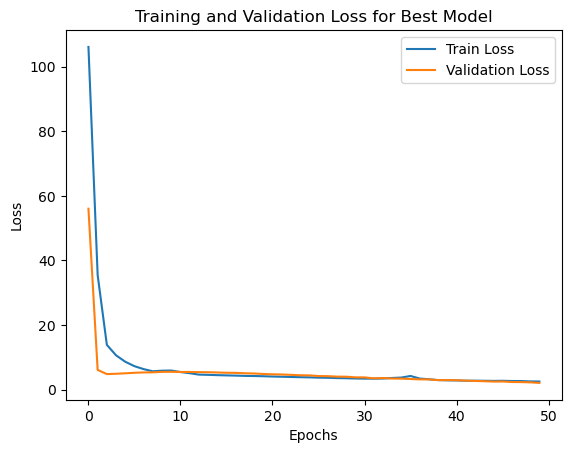

In [21]:
features = ['0Z_alpha','1Z_alpha','2Z_alpha','3Z_alpha','1L_alpha','1R_alpha','1LB_alpha','1RB_alpha',
           '2L_alpha','2R_alpha','3L_alpha','3R_alpha','4L_alpha','4R_alpha','1LC_alpha','1RC_alpha',
           '2LB_alpha','1LA_alpha','1RA_alpha','1LD_alpha','2LC_alpha','2RC_alpha','3LB_alpha','3RB_alpha',
           '2LD_alpha','2RD_alpha','3RD_alpha','3LD_alpha','9Z_alpha','8Z_alpha','7Z_alpha',
           '6Z_alpha','10L_alpha','10R_alpha','9L_alpha','9R_alpha','8L_alpha','8R_alpha','7L_alpha',
           '7R_alpha','6L_alpha','5R_alpha','4LD_alpha','4RD_alpha','5LC_alpha','5RC_alpha','5LB_alpha',
           '5RB_alpha','3LA_alpha','3RA_alpha','2LA_alpha','2RA_alpha','4LC_alpha','4RC_alpha','4LB_alpha',
           '4RB_alpha','4Z_alpha','2RB_alpha','1RD_alpha','3LC_alpha','3RC_alpha','6R_alpha','5L_alpha',
           '5Z_alpha','0Z_beta','1Z_beta','2Z_beta','3Z_beta', '1L_beta','1R_beta','1LB_beta','1RB_beta',
           '2L_beta','2R_beta','3L_beta','3R_beta','4L_beta','4R_beta','1LC_beta','1RC_beta',
           '2LB_beta','1LA_beta','1RA_beta','1LD_beta','2LC_beta','2RC_beta','3LB_beta','3RB_beta',
           '2LD_beta','2RD_beta','3RD_beta','3LD_beta','9Z_beta','8Z_beta','7Z_beta',
           '6Z_beta','10L_beta','10R_beta','9L_beta','9R_beta','8L_beta','8R_beta','7L_beta',
           '7R_beta','6L_beta','5R_beta','4LD_beta','4RD_beta','5LC_beta','5RC_beta','5LB_beta',
           '5RB_beta','3LA_beta','3RA_beta','2LA_beta','2RA_beta','4LC_beta','4RC_beta','4LB_beta',
           '4RB_beta','4Z_beta','2RB_beta','1RD_beta','3LC_beta','3RC_beta','6R_beta','5L_beta',
           '5Z_beta','0Z_gamma','1Z_gamma','2Z_gamma','3Z_gamma', '1L_gamma','1R_gamma','1LB_gamma','1RB_gamma',
           '2L_gamma','2R_gamma','3L_gamma','3R_gamma','4L_gamma','4R_gamma','1LC_gamma','1RC_gamma',
           '2LB_gamma','1LA_gamma','1RA_gamma','1LD_gamma','2LC_gamma','2RC_gamma','3LB_gamma','3RB_gamma',
           '2LD_gamma','2RD_gamma','3RD_gamma','3LD_gamma','9Z_gamma','8Z_gamma','7Z_gamma',
           '6Z_gamma','10L_gamma','10R_gamma','9L_gamma','9R_gamma','8L_gamma','8R_gamma','7L_gamma',
           '7R_gamma','6L_gamma','5R_gamma','4LD_gamma','4RD_gamma','5LC_gamma','5RC_gamma','5LB_gamma',
           '5RB_gamma','3LA_gamma','3RA_gamma','2LA_gamma','2RA_gamma','4LC_gamma','4RC_gamma','4LB_gamma',
           '4RB_gamma','4Z_gamma','2RB_gamma','1RD_gamma','3LC_gamma','3RC_gamma','6R_gamma','5L_gamma',
           '5Z_gamma','0Z_theta','1Z_theta','2Z_theta','3Z_theta', '1L_theta','1R_theta','1LB_theta','1RB_theta',
           '2L_theta','2R_theta','3L_theta','3R_theta','4L_theta','4R_theta','1LC_theta','1RC_theta',
           '2LB_theta','1LA_theta','1RA_theta','1LD_theta','2LC_theta','2RC_theta','3LB_theta','3RB_theta',
           '2LD_theta','2RD_theta','3RD_theta','3LD_theta','9Z_theta','8Z_theta','7Z_theta',
           '6Z_theta','10L_theta','10R_theta','9L_theta','9R_theta','8L_theta','8R_theta','7L_theta',
           '7R_theta','6L_theta','5R_theta','4LD_theta','4RD_theta','5LC_theta','5RC_theta','5LB_theta',
           '5RB_theta','3LA_theta','3RA_theta','2LA_theta','2RA_theta','4LC_theta','4RC_theta','4LB_theta',
           '4RB_theta','4Z_theta','2RB_theta','1RD_theta','3LC_theta','3RC_theta','6R_theta','5L_theta',
           '5Z_theta','kcpt_detectability_t','kcpt_omissions_t','kcpt_commissions_t','kcpt_hrt_score', 'kcpt_variability_t','kcpt_hrt_block_tscore','kcpt_hrt_isi_tscore']

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# Split the data into features and target
X = data[features]
y = data['wppsi_fsiq_scaled']

# Check for missing values and handle them
X.fillna(0, inplace=True)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the base neural network model for regression
def create_model():
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

batch_sizes = [1, 5, 10, 20, 50]  # Sample sizes
epoch_counts = [10, 20, 30, 40, 50]  # Sample epochs

# List to store the results
results = []

for batch_size in batch_sizes:
    for epochs in epoch_counts:
        # Reinitialize the model to ensure fresh weights
        model = create_model()
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

        # Train the model with the current batch size and number of epochs
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,  # Use 10% of training data for validation
            verbose=0
        )

        # Record the final validation loss for this combination
        final_val_loss = history.history['val_loss'][-1]
        results.append((batch_size, epochs, final_val_loss))

# Convert results to a numpy array for easier analysis
results = np.array(results, dtype=object)

# Find the batch size and epoch count with the lowest validation loss
best_index = np.argmin(results[:, 2].astype(float))
best_batch_size, best_epochs, best_val_loss = results[best_index]

print(f"Best batch size: {best_batch_size}, Best epochs: {best_epochs}, Validation loss: {best_val_loss}")

# Reinitialize and train the model with the best batch size and epochs
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=int(best_epochs),
    batch_size=int(best_batch_size),
    validation_split=0.1,
    verbose=1
)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}, Test MAE: {mae}')

# Predict IQ scores for the entire dataset
y_pred_full = model.predict(X_scaled)

# Add predictions to the full dataset
data['wppsi_fsiq_scaled_predicted'] = y_pred_full

# Visualize training history for the best model
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for Best Model')
plt.show()


In [22]:
display(data[['wppsi_fsiq_scaled', 'wppsi_fsiq_scaled_predicted']])

,wppsi_fsiq_scaled,wppsi_fsiq_scaled_predicted
0,12.0,11.440974
1,9.5,9.280244
2,8.0,11.213737
3,12.5,12.064200
4,11.5,9.524354
5,12.0,10.865180
6,9.0,8.232292
7,13.0,10.769109
8,12.0,9.277206
9,11.0,9.697973


In [23]:
# Compute permutation importance
results = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')

# Get feature importances
importance = results.importances_mean

# Print feature importances
for i, feature in enumerate(features):
    print(f"Feature: {feature}, Importance: {importance[i]}")
    
# High Positive Importance: Features with high positive importance values (e.g., 0_2000ms_Rest_1LB_beta, 0_2000ms_Rest_9L_beta, 0_2000ms_Rest_3LA_gamma) are strong contributors to the model's predictions. They have a significant impact on the outcome and are likely crucial for the model’s performance.

# Low or Negative Importance: Features with low or negative importance values (e.g., 0_2000ms_Rest_2Z_beta, 0_2000ms_Rest_3R_beta, 0_2000ms_Rest_4R_gamma) contribute less or even detract from the model's performance. These might be less relevant for predicting the target variable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

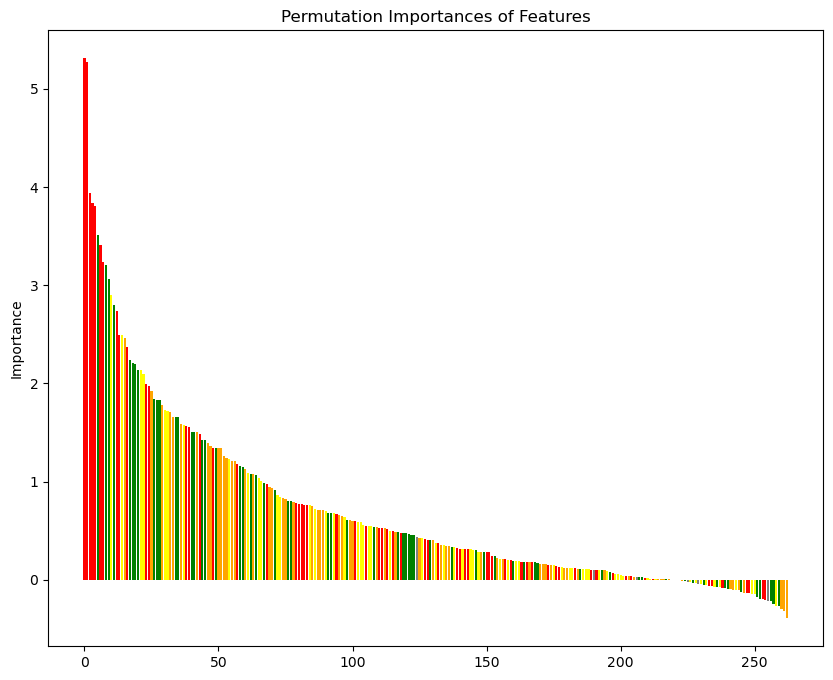

In [25]:
# Define colors for each frequency band
color_map = {
    '_alpha': 'yellow',  
    '_beta': 'orange',   
    '_theta': 'green',  
    '_gamma': 'red'   
}

# Assign colors based on feature names
colors = []
for feature in features:
    for band, color in color_map.items():
        if band in feature:
            colors.append(color)
            break
    else:
        colors.append('gray')  # Default color if none of the bands match

# Sort features by importance
indices = np.argsort(importance)[::-1]

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(range(len(features)), np.array(importance)[indices], color=np.array(colors)[indices], align='center')
plt.ylabel('Importance')
plt.title('Permutation Importances of Features')
plt.show()

In [31]:
# Define distinct colors for each frequency band
color_map = {
    '_alpha': 'yellow',  
    '_beta': 'orange',   
    '_theta': 'green',  
    '_gamma': 'red'   
}

# Assign colors based on feature names
colors = []
for feature in features:
    for band, color in color_map.items():
        if band in feature:
            colors.append(color)
            break
    else:
        colors.append('gray')  # Default color if none of the bands match

# Sort features by importance
indices = np.argsort(importance)[::-1]
sorted_features = np.array(features)[indices]
sorted_importance = np.array(importance)[indices]
sorted_colors = np.array(colors)[indices]

# Create the interactive plot
fig = go.Figure(data=[go.Bar(
    x=sorted_features,
    y=sorted_importance,
    marker_color=sorted_colors
)])

fig.update_layout(
    title='Permutation Importances of Features',
    xaxis_title='Features',
    yaxis_title='Importance',
    xaxis_tickangle=-45
)
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

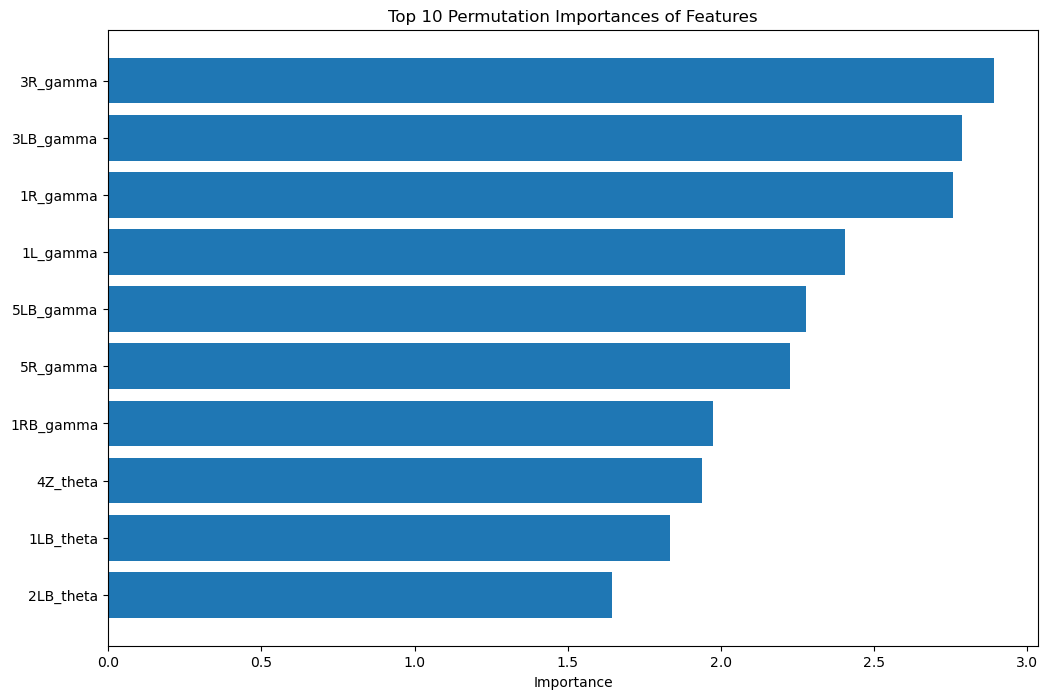

In [27]:
# Compute permutation importance
results = permutation_importance(model, X_test, y_test, scoring='neg_mean_squared_error')

# Get feature importances
importance = results.importances_mean

# Number of top features to display
top_n = 10

# Get indices of top N features
indices = np.argsort(importance)[::-1][:top_n]

# Print top N feature importances
for i in indices:
    print(f"Feature: {features[i]}, Importance: {importance[i]}")

# Plot top N feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), importance[indices], align='center')
plt.yticks(range(top_n), np.array(features)[indices])
plt.xlabel('Importance')
plt.title('Top 10 Permutation Importances of Features')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [32]:
from nilearn import plotting
dmn_coords = [(40,-33.6,82.5), (-5.4,86.9,29.9), (89.7,-28.5,18.7), (89.2,30.4,17.3),(89.2,30.4,17.3),(-38.2,-34,91.1),(74.3,-51.6,36.2),(-21.9,0.1,99.4),(71.1,54.4,34.3),(38.7,77.7,31)]
view = plotting.view_markers(dmn_coords, ['red', 'red', 'red','red','red','red','red','green','green','green'],
                             marker_size=10)
view.open_in_browser()

# https://nilearn.github.io/stable/plotting/index.html